In [1]:
import os, glob
import pandas as pd
import numpy as np
import locale
from locale import atof

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Extract Data

In [2]:
path = "C:/Users/iqbal/Desktop/Code/crunchbase test/Crunchbase Data"
all_files = glob.glob(os.path.join(path, "*.csv"))

data = pd.concat([pd.read_csv(f) for f in all_files ])

# data.to_csv("combined_csv.csv", index=False)

In [3]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
plt.rcParams["figure.figsize"] = (20,5)
# data.head()
# data.info()

## Clean Data and Explore Data

In [4]:
# dfMain = data.drop(columns=["Organization Name", 'Last Funding Type', "Industries", "Operating Status", "Headquarters Location", 
#                             "Founded Date", "Organization Name URL", "CB Rank (Company)", "Founded Date Precision",
#                             "Exit Date", "Exit Date Precision", "Closed Date", "Closed Date Precision", "Company Type",
#                             "Investment Stage", "Founders", "Top 5 Investors", "Last Funding Amount Currency","Last Funding Date", "Last Funding Amount", "Last Equity Funding Amount","Last Equity Funding Amount Currency",
#                            "Total Equity Funding Amount Currency", "Total Equity Funding Amount", "Total Funding Amount",
#                             "Total Funding Amount Currency", "Number of Acquisitions", "Acquisition Status", 
#                             "IPO Status", "IPO Date", "Delisted Date", "Delisted Date Precision", 
#                             "Money Raised at IPO", "Money Raised at IPO Currency",
#                             "Money Raised at IPO Currency (in USD)", "Valuation at IPO", "Valuation at IPO Currency",
#                             "Valuation at IPO Currency (in USD)", "Stock Symbol", "Stock Symbol URL", "Stock Exchange", 
#                             "IPqwery - Patents Granted", "IPqwery - Trademarks Registered", 
#                             "IPqwery - Most Popular Patent Class", "IPqwery - Most Popular Trademark Class", 
#                             "Investor Type", "Accelerator Program Type", "Accelerator Duration (in weeks)" ,
#                             "Acquisition Type", "G2 Stack - Total Products Active", "Aberdeen - IT Spend",
#                             "Aberdeen - IT Spend Currency", "Aberdeen - IT Spend Currency (in USD)",
#                             "SEMrush - Monthly Visits", "SEMrush - Average Visits (6 months)", "SEMrush - Monthly Visits Growth",
#                             "SEMrush - Visit Duration", "SEMrush - Page Views / Visit", "SEMrush - Visit Duration Growth",
#                             "SEMrush - Page Views / Visit Growth", "SEMrush - Bounce Rate", "SEMrush - Bounce Rate Growth",
#                             "SEMrush - Global Traffic Rank", "SEMrush - Monthly Rank Change (#)", "SEMrush - Monthly Rank Growth" 
#                           ])

dfMain = data[["Organization Name",'Number of Articles', 'Headquarters Regions',
               'Estimated Revenue Range', 'Industry Groups', 'Number of Founders', "Founded Date",
               'Number of Employees', 'Number of Funding Rounds',
               'Last Funding Amount Currency (in USD)', 
               'Last Equity Funding Amount Currency (in USD)',
               'Last Equity Funding Type',
               'Total Equity Funding Amount Currency (in USD)',
               'Total Funding Amount Currency (in USD)', 'Number of Lead Investors',
               'Number of Investors', 'BuiltWith - Active Tech Count', "SEMrush - Monthly Visits",
               'SEMrush - Average Visits (6 months)', "SEMrush - Visit Duration", "SEMrush - Page Views / Visit",
              ]]


dfMain=dfMain.dropna()

In [5]:
dfMain['Date 2'] = pd.to_datetime(dfMain["Founded Date"], errors="coerce")
dfMain["Date 3"] = pd.DatetimeIndex(dfMain["Date 2"]).year
dfMain["Years Active"] = 2020  - dfMain["Date 3"]

In [6]:
# dfMain["Estimated Revenue Range"].value_counts()
# BigCompanies = dfMain.loc[dfMain["Estimated Revenue Range"] == "$10B+"]
# BigCompanies

In [7]:
dfMain["Estimated Revenue Range"].value_counts()

$1M to $10M       5084
$10M to $50M      2302
Less than $1M     2204
$100M to $500M     663
$50M to $100M      568
$1B to $10B        142
$500M to $1B       135
$10B+               33
Name: Estimated Revenue Range, dtype: int64

In [8]:
#Remove Outliers
dfMain = dfMain[dfMain["Estimated Revenue Range"] != "$10B+"]


#Initialize empty columns
dfMain["Industry"]=np.nan
dfMain["Count"]=np.nan

# Get First value of Industry Group
dfMain["Industry"] = dfMain["Industry Groups"].str.split(',')
dfMain["Industry"] = dfMain["Industry"].apply(lambda x: x[0])

# Create Years Founded Variable
dfMain['Years Active'] = pd.to_datetime(dfMain["Founded Date"], errors="coerce")
dfMain["Years Active"] = pd.DatetimeIndex(dfMain["Years Active"]).year
dfMain["Years Active"] = 2020  - dfMain["Years Active"]
dfMain["Years Active"].fillna(10, inplace=True)


#Set Categorical and numeric variables
cat_vars = dfMain[["Headquarters Regions", "Industry", "Estimated Revenue Range", "Number of Employees",]]

num_vars = dfMain[['Number of Articles', 'Number of Founders', 'Number of Funding Rounds', 'Years Active',
                   'Last Funding Amount Currency (in USD)',
                   'Last Equity Funding Amount Currency (in USD)',
                   'Total Equity Funding Amount Currency (in USD)',
                   'Total Funding Amount Currency (in USD)', 'Number of Lead Investors',
                   'Number of Investors', 'BuiltWith - Active Tech Count', "SEMrush - Monthly Visits",
                   'SEMrush - Average Visits (6 months)', "SEMrush - Visit Duration", "SEMrush - Page Views / Visit"
                    ]]


#Apply One hot encode
ohe = OneHotEncoder()
transformed_cat_vars = ohe.fit_transform(cat_vars.astype(str))
feat_names = ohe.get_feature_names()


#Handle Headerquarters regions with low values
dfMain["Count"]=dfMain.groupby("Headquarters Regions").transform('count')
dfMain["Headquarters Regions"].loc[dfMain["Count"] < 20 ] = "Other"

#Remove commas from numbers
locale.setlocale(locale.LC_NUMERIC, '')
num_vars = num_vars.astype(str)
num_vars = num_vars.applymap(atof)



#scale numerical variables
scaled_num_vars = preprocessing.StandardScaler().fit_transform(num_vars)


# transformed_vars = pd.concat([num_vars, transformed_cat_vars], axis=1)

#Create Target Variable
targetValues = ["Series A", "Series B", "Series C", "Series D", "Series E", "Series F", 
                "Series G",  "Series H", "Series I", "Series J", "Post-IPO Equity"]

dfMain["Has Reached Series A"]=dfMain["Last Equity Funding Type"].isin(targetValues)

C:\Users\iqbal\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
dfMain["Industry"].nunique()

42

## Analyze Data

In [10]:
dfMain["Has Reached Series A"].value_counts()

True     6490
False    4608
Name: Has Reached Series A, dtype: int64

In [11]:
num_vars.corrwith(dfMain["Has Reached Series A"])

Number of Articles                              -0.007323
Number of Founders                               0.077417
Number of Funding Rounds                         0.114631
Years Active                                    -0.049818
Last Funding Amount Currency (in USD)            0.048748
Last Equity Funding Amount Currency (in USD)     0.032204
Total Equity Funding Amount Currency (in USD)    0.019229
Total Funding Amount Currency (in USD)           0.018138
Number of Lead Investors                         0.215619
Number of Investors                              0.222137
BuiltWith - Active Tech Count                    0.081618
SEMrush - Monthly Visits                         0.010303
SEMrush - Average Visits (6 months)              0.010361
SEMrush - Visit Duration                         0.035443
SEMrush - Page Views / Visit                     0.026032
dtype: float64

In [12]:
# pd.crosstab(dfMain['Estimated Revenue Range'] ,dfMain["Has Reached Series A"]).plot(kind='bar')
# sns.catplot(x="Has Reached Series A", y="SEMrush - Page Views / Visit", kind="box", data=dfMain)

In [13]:

# calculate the fpr and tpr for all thresholds of the classification




## Predict Data

In [20]:


# x = scaled_num_vars
x = transformed_cat_vars


y = dfMain["Has Reached Series A"]
x_train, x_test, y_train, y_test = train_test_split(x, y)

clf = RandomForestClassifier().fit(x_train, y_train)
# clf = LogisticRegression().fit(x_train, y_train)

# print(np.c_[feat_names, clf.feature_importances_])
# print(pd.DataFrame({"Features":feat_names, "Importances":  clf.feature_importances_}).sort_values(by='Importances') )
# print(pd.DataFrame({"Features":num_vars.columns, "Importances":  clf.feature_importances_}).sort_values(by='Importances') )


# print(pd.DataFrame({"Features": num_vars.columns.tolist(), "Coeff": np.exp(clf.coef_[0]) }) )
# df5 = pd.DataFrame({"Features": feat_names, "Coeff": np.exp(clf.coef_[0]) }) 

prediction = clf.predict(x_test)
print(accuracy_score(y_test, prediction))


0.5927927927927928


In [18]:
pd.set_option('display.max_rows', 105)
# df5.sort_values(by="Coeff")


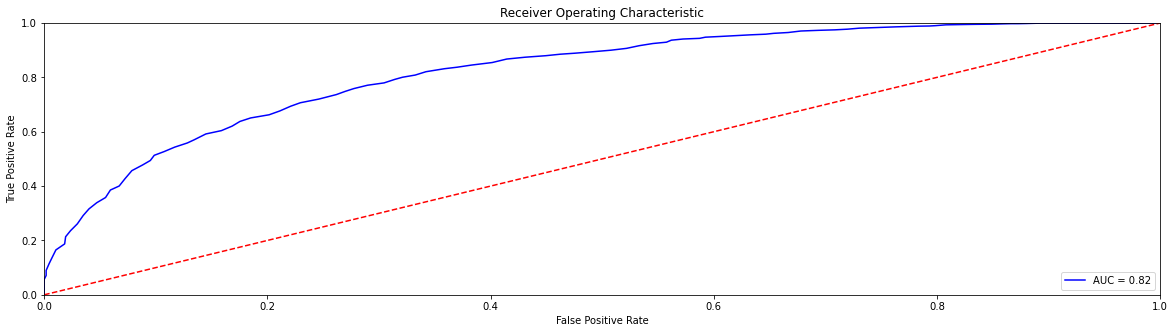

In [16]:
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()